# Importation des packages

On commence par importer les packages dont on aura besoin dans toute la suite.

In [ ]:
import IPython

import scipy
import numpy as np # manipulate N-dimensional arrays
import pandas as pd # data frame
import matplotlib.pyplot as plt # data plotting
import seaborn as sns # advanced data plotting
from sklearn import preprocessing # basic ML models
# import scipy # scientific computing library

import tensorflow as tf
import keras

from sklearn.model_selection import train_test_split # Séparation train-validation-test
from collections import Counter # Permet de compter le nombre d'éléments qui possèdent chaque label
from keras.utils import to_categorical # One-hot encoding

from keras.models import Model, Sequential
from keras.layers import Input, Dense, BatchNormalization, Dropout, ReLU, Activation, Flatten, Conv2D, MaxPooling2D

from keras.backend import clear_session
from keras.optimizers import Adam

from keras.callbacks import EarlyStopping

import os
from keras import backend as K

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

from tqdm import tqdm #progress bar

from scipy.ndimage import gaussian_filter
import random


Le package kerastuner n'étant pas présent de base, il faut l'installer.
<br>
Ce dernier nous permettra d'optimiser les hyperparamètres de nos modèles.

In [ ]:
!pip install -q -U keras-tuner
import kerastuner as kt # Hyperparameter optimisation

In [ ]:
print(tf.__version__)

2.4.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Préparation des données

## Chargement du dataset MNIST

On charge le jeu de données MNIST en indiquant qu'on veut le nombre de channels en dernière dimension.

In [ ]:
K.set_image_data_format('channels_last')

(x_train_original, y_train_original), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
# x_train_original, x_test = x_train_original[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train_original))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


Le train contient 60 000 images de taille 28 $\times$ 28.
<br>
Le test contient 10 000 images de taille 28 $\times$ 28.
<br>
Comme on n'a pas de 4ème dimension, on en déduit que ces images sont en noir et blanc.


In [ ]:
print(x_train_original.shape)
print(x_test.shape)
print(y_train_original.shape)
print(y_test.shape)

(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


Le nombre de labels possibles est 10: tous les chiffres de 0 à 9.

In [ ]:
num_classes = y_train_original.max() +1
num_classes

10

On affiche la seconde image du jeu de données ainsi que son label.

0


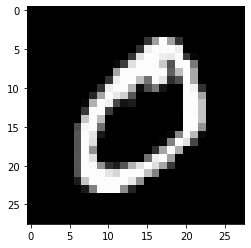

In [ ]:
print(y_train_original[1])

# plt.imshow(x_train_original[0, :, :, 0])
plt.imshow(x_train_original[1], cmap = "gray")
# plt.colorbar()

## Séparation des données

On sépare le jeu de données d'entraînement initial en trois parties.
<br>
On commence d'abord par isoler 100 images. Ces 100 images serviront à construire notre baseline, c'est-à-dire nos modèles supervisés.

On sépare ensuite les 59900 images restantes en deux parties.
<br>
On isole 10 000 images pour créer un jeu de données de validation qui nous servira notamment dans le réglage des hyperparamètres.
<br>

Les 49900 images restantes seront des données considérées comme "sans label".
Ces images nous serviront uniquement lors de la suite du projet, pour construire nos modèles semi-supervisés.

In [ ]:
x_labeled, x_tmp, y_labeled, y_tmp = train_test_split(
    x_train_original, y_train_original, test_size=59900, random_state = 18, shuffle = True, stratify = y_train_original)

x_unlabeled, x_val, _, y_val = train_test_split(
    x_tmp, y_tmp, test_size=10000, random_state = 18, shuffle = True, stratify = y_tmp)

del x_tmp
del y_tmp

On vérifie que l'on a bien les bonnes dimensions.

In [ ]:
# Labeled data
print(x_labeled.shape)
print(y_labeled.shape)

# Unlabeled data
print(x_unlabeled.shape)


# Validation data
print(x_val.shape)
print(y_val.shape)

(100, 28, 28)
(100,)
(49900, 28, 28)
(10000, 28, 28)
(10000,)


On vérifie que nos 100 images labélisées sont bien balancées.

In [ ]:
Counter(list(y_labeled.reshape(-1)))

Counter({0: 10, 1: 11, 2: 10, 3: 10, 4: 10, 5: 9, 6: 10, 7: 10, 8: 10, 9: 10})

On vérifie que nos données de validation sont bien balancées.

In [ ]:
Counter(list(y_val.reshape(-1)))

Counter({0: 987,
         1: 1124,
         2: 993,
         3: 1022,
         4: 974,
         5: 904,
         6: 986,
         7: 1044,
         8: 975,
         9: 991})

## Normalisation des données

On normalise les données pour qu'elles soient comprises entre 0 et 1.
<br>
Les valeurs de chaque pixel étant comprises entre 0 et 255, il suffit de diviser par 255 pour normaliser.

---




In [ ]:
# Conversion en réel
x_train_original = x_train_original.astype('float32')
x_test = x_test.astype('float32')
x_labeled = x_labeled.astype('float32')
x_val = x_val.astype('float32')
x_unlabeled = x_unlabeled.astype('float32')

In [ ]:
# Normalisation
x_train_original /= 255
x_test /= 255
x_labeled /= 255
x_val /= 255
x_unlabeled /= 255

One-hot encoding.

In [ ]:
y_train_original = to_categorical(y_train_original, num_classes)
y_test = to_categorical(y_test, num_classes)
y_labeled = to_categorical(y_labeled, num_classes)
y_val = to_categorical(y_val, num_classes)

# Création des réseaux de neurones supervisés (baseline)

## Optimisation des hyperparamètres

### Perceptron multicouches (MLP)

In [ ]:
clear_session()

#### Définition de l'HyperModel





On définit la structure du modèle perceptron multicouches à optimiser.

Notre modèle comportera une couche d'entrée avec un nombre de neurones appartenant à l'ensenble $\{64, 128, 256\}$. Cette couche d'entrée sera suivie d'une Batch Normalization, d'une activation ReLU et d'un dropout dont le taux appartiendra à l'ensemble $\{0.4, 0.5, 0.6\}$.

Ensuite, le nombre de couches câchées sera compris entre 1 et 2 et chacune de ces couches sera construite comme la couche d'entrée.

Enfin, notre modèle comportera une couche de sortie composée de 10 neurones (nombre de classes) et d'une activation softmax.

L'optimiseur que l'on utilisera sera l'optimiseur Adam, et son pas d'apprentissage sera fixé à $10^{-3}$.

In [ ]:
def model_builder(hp):
  model_MLP = Sequential()
  model_MLP.add(Flatten(input_shape=(28, 28))) #dimension des images  

  # Couche d'entrée
  model_MLP.add(Dense(units = hp.Choice(name = 'input_layer_units',
                                        values = [64, 128, 256]),
                      input_shape = (784,))) # 28 * 28 = 784
  model_MLP.add(BatchNormalization())
  model_MLP.add(ReLU())
  model_MLP.add(Dropout(rate = hp.Choice(name = 'input_layer_dropout_rate',
                                         values = [0.4, 0.5, 0.6])))

  # Couches câchées: on décide de créer entre 1 et 2 couches câchées
  for i in range(hp.Int('n_hidden_layers', min_value = 1, max_value = 2)):
        model_MLP.add(Dense(units = hp.Choice(name = f'hidden_layer_{i+1}_units',
                                              values = [64,128, 256])))
        model_MLP.add(BatchNormalization()) #regularization on the fully connected network
        model_MLP.add(ReLU())
        model_MLP.add(Dropout(rate = hp.Choice(name = f'hidden_layer_{i+1}_dropout_rate',
                                               values = [0.4, 0.5, 0.6])))

  # Couche de sortie
  model_MLP.add(Dense(num_classes, activation = 'softmax'))

  # Optimiseur
  model_MLP.compile(optimizer = Adam(learning_rate = 1e-3),
                    loss = keras.losses.CategoricalCrossentropy(from_logits = False), 
                    metrics = ['accuracy'])
  
  return model_MLP

On définit la façon dont on va chercher le modèle optimal.
<br>
Ici, on essaye 25 modèles en choisissant de manière aléatoire leurs paramètres parmis ceux proposés.
<br>
On fixe la graine à 1 afin de rendre nos résultats reproductibles.
<br>
On testera chacun de ces modèles une seule fois et un sauvegardera les résultats dans un dossier Google Drive.

In [ ]:
tuner = kt.RandomSearch(
    model_builder,
    objective='val_accuracy',
    max_trials=25,
    executions_per_trial=1,
    seed = 1,
    directory='/content/drive/My Drive/MNIST_baseline',
    project_name='KerasTuner_baseline_MLP')

INFO:tensorflow:Reloading Oracle from existing project /content/drive/My Drive/MNIST_baseline/KerasTuner_baseline_MLP/oracle.json
INFO:tensorflow:Reloading Tuner from /content/drive/My Drive/MNIST_baseline/KerasTuner_baseline_MLP/tuner0.json


#### Entrainement de l'HyperModel

Ce callback permet d'effacer les sorties d'entrainement après chaque étape d'entrainement.


In [ ]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

On effectue la recherche des hyperparamètres optimaux.
<br>
On les sauvegarde ensuite dans la variable **best_hps_MLP** pour pouvoir définir le modèle optimal ensuite.

In [ ]:
epochs_number = 20

tuner.search(x_labeled, y_labeled, epochs = epochs_number,
             validation_data = (x_val, y_val), callbacks = [ClearTrainingOutput()])

# Hyperparamètres optimaux
best_hps_MLP = tuner.get_best_hyperparameters()[0]

INFO:tensorflow:Oracle triggered exit


### Réseau de convolution (CNN)

In [ ]:
clear_session()

#### Définition de l'HyperModel

On définit la structure du modèle CNN à optimiser.

Notre modèle comportera une première couche de convolution avec un nombre de filtres appartenant à l'ensemble $\{16, 32, 64\}$. Les filtres seront de dimension $(1, 1)$ et le stride sera de dimension $(1, 1)$. Cette couche sera suivie d'une activation ReLU.

Ensuite, il y aura un bloc d'une ou deux couches de convolutions de la même façon que précédemment. Après ce bloc, on effectuera un Max Pooling de dimension $(2,2)$ et un dropout avec un taux appartenant à l'ensemble $\{0.5, 0.6, 0.7\}$

Après cela s'ajoutera un bloc d'une ou deux couches complètement connectées (FC layers). Une couche contiendra ici un nombre de neurones appartenant à l'ensemble $\{64, 128, 256\}$ et sera suivie d'une batch normalization, d'une activation ReLU et d'un dropout avec un taux appartenant au même ensemble que précédemment.

Enfin, notre modèle comportera une couche de sortie composée de 10 neurones (nombre de classes) et d'une activation softmax.

L'optimiseur que l'on utilisera sera l'optimiseur Adam, et son pas d'apprentissage sera fixé à $10^{-3}$.

In [ ]:
def model_builder_CNN(hp):

  model_CNN = Sequential()

  # Première couche de convolution
  model_CNN.add(Conv2D(filters = hp.Choice(name = 'input_conv_filters',
                                           values = [16, 32, 64]),
                       kernel_size = (1, 1), padding='same', strides = (1, 1),
                       input_shape=(28,28,1)))
  model_CNN.add(ReLU())

  # Bloc de 1 ou 2 couche(s) de convolution. Ce bloc est suivie d'un max pooling et d'un dropout
  for i in range(hp.Int('n_layers', min_value = 1, max_value = 2)):
    model_CNN.add(Conv2D(filters = hp.Choice(name = f'conv_{i+1}_filters',
                                             values = [16, 32, 64]),
                         kernel_size = (1,1), padding='same', strides = (1,1)))
    model_CNN.add(ReLU())
  model_CNN.add(MaxPooling2D(pool_size=(2, 2)))
  model_CNN.add(Dropout(rate = hp.Choice(name = 'conv_dropout_rate',
                                               values = [0.5, 0.6, 0.7])))
  
  # Partie dense
  model_CNN.add(Flatten())
  ## Couches complètement connectées: on décide d'en créer entre 1 et 2
  for i in range(hp.Int('n_FC_layers', min_value = 1, max_value = 2)):
        model_CNN.add(Dense(units = hp.Choice(name = f'FC_layer_{i+1}_units',
                                              values = [64, 128, 256])))
        model_CNN.add(BatchNormalization())
        model_CNN.add(ReLU())
        model_CNN.add(Dropout(rate = hp.Choice(name = f'FC_layer_{i+1}_dropout_rate',
                                               values = [0.5, 0.6, 0.7])))


  ## Couche de sortie
  model_CNN.add(Dense(num_classes, activation = 'softmax'))

 
  model_CNN.compile(optimizer = Adam(learning_rate = 1e-3),
                    loss = keras.losses.CategoricalCrossentropy(from_logits = False), 
                    metrics = ['accuracy'])
  
  return model_CNN

#### Entrainement de l'HyperModel

On définit la façon dont on va chercher le modèle optimal.
<br>
Ici, on essaye 25 modèles en choisissant de manière aléatoire leurs paramètres parmis ceux proposés.
<br>
On fixe la graine à 1 afin de rendre nos résultats reproductibles.
<br>
On testera chacun de ces modèles une seule fois et un sauvegardera les résultats dans un dossier Google Drive.

In [ ]:
tuner_CNN = kt.RandomSearch(
    model_builder_CNN,
    objective='val_accuracy',
    max_trials=25,
    executions_per_trial=1,
    seed = 1,
    directory='/content/drive/My Drive/MNIST_baseline',
    project_name='KerasTuner_baseline_CNN')

INFO:tensorflow:Reloading Oracle from existing project /content/drive/My Drive/MNIST_baseline/KerasTuner_baseline_CNN/oracle.json
INFO:tensorflow:Reloading Tuner from /content/drive/My Drive/MNIST_baseline/KerasTuner_baseline_CNN/tuner0.json


On effectue la recherche des hyperparamètres optimaux.
<br>
On les sauvegarde ensuite dans la variable **best_hps_CNN** pour pouvoir définir le modèle optimal ensuite.

In [ ]:
epochs_number = 20

# On doit faire un reshape pour avoir le channel dans une dimension
tuner_CNN.search(x_labeled.reshape(len(x_labeled),28,28,1), y_labeled, epochs = epochs_number,
                 validation_data = (x_val.reshape(len(x_val),28,28,1), y_val), callbacks = [ClearTrainingOutput()])

# Meilleurs hyperparamètres
best_hps_CNN = tuner_CNN.get_best_hyperparameters()[0]

INFO:tensorflow:Oracle triggered exit


## Modèles optimaux

### Perceptron multicouches (MLP)

In [ ]:
clear_session()

#### Entrainement

On commence par afficher les hyperparamètres optimaux.

In [ ]:
print(best_hps_MLP.values)

{'input_layer_units': 128, 'input_layer_dropout_rate': 0.5, 'n_hidden_layers': 1, 'hidden_layer_1_units': 256, 'hidden_layer_1_dropout_rate': 0.5, 'hidden_layer_2_units': 256, 'hidden_layer_2_dropout_rate': 0.6}


On construit ensuite le modèle optimal.

In [ ]:
best_model_MLP = tuner.hypermodel.build(best_hps_MLP)

On affiche un résumé de ce modèle.

In [ ]:
best_model_MLP.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
re_lu (ReLU)                 (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1

On entraine le modèle optimal sur 100 epochs avec une taille de batch égale à 32. <br>
On veille également à ajouter un Early Stopping afin d'améliorer les performances de notre modèle.

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 10)
hist_best_model_MLP = best_model_MLP.fit(x_labeled, y_labeled,
                                         epochs = 100,
                                         batch_size = 16,
                                         validation_data = (x_val, y_val),
                                         shuffle = True, callbacks = [es])

Epoch 1/100
7/7 [==============================] - 2s 187ms/step - loss: 3.2997 - accuracy: 0.0339 - val_loss: 2.2796 - val_accuracy: 0.1828
Epoch 2/100
7/7 [==============================] - 1s 105ms/step - loss: 2.6938 - accuracy: 0.2032 - val_loss: 2.1818 - val_accuracy: 0.3065
Epoch 3/100
7/7 [==============================] - 1s 101ms/step - loss: 2.1326 - accuracy: 0.2926 - val_loss: 2.0807 - val_accuracy: 0.3856
Epoch 4/100
7/7 [==============================] - 1s 110ms/step - loss: 1.9546 - accuracy: 0.3736 - val_loss: 1.9877 - val_accuracy: 0.4365
Epoch 5/100
7/7 [==============================] - 1s 106ms/step - loss: 1.6916 - accuracy: 0.4245 - val_loss: 1.9035 - val_accuracy: 0.4684
Epoch 6/100
7/7 [==============================] - 1s 107ms/step - loss: 1.4421 - accuracy: 0.5276 - val_loss: 1.8202 - val_accuracy: 0.4899
Epoch 7/100
7/7 [==============================] - 1s 108ms/step - loss: 1.3426 - accuracy: 0.5118 - val_loss: 1.7382 - val_accuracy: 0.5278
Epoch 8/100
7

On sauvegarde le modèle optimal après entrainement pour pouvoir le réutiliser directement.


In [ ]:
model_save_name = 'optimal_model_MLP'
path = F"/content/drive/My Drive/MNIST_baseline/{model_save_name}" 
best_model_MLP.save(path)

INFO:tensorflow:Assets written to: /content/drive/My Drive/MNIST_baseline/optimal_model_MLP/assets


#### Résultats

On affiche les résultats obtenus. Ici, on affiche l'accuracy du modèle en fonction du nombre d'epochs.



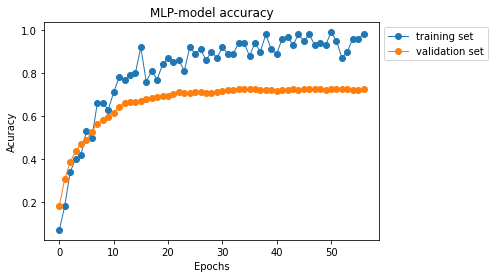

In [ ]:
plt.plot(hist_best_model_MLP.history['accuracy'], label='training set',marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.plot(hist_best_model_MLP.history['val_accuracy'], label='validation set',marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.title("MLP-model accuracy")
plt.xlabel('Epochs')
plt.ylabel('Acuracy')
plt.legend(bbox_to_anchor=( 1., 1.))

Ici, on affiche la loss du modèle en fonction du nombre d'epochs.

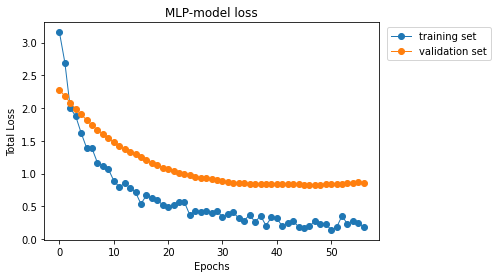

In [ ]:
plt.plot(hist_best_model_MLP.history['loss'], label='training set',marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.plot(hist_best_model_MLP.history['val_loss'], label='validation set',marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.title("MLP-model loss")
plt.xlabel('Epochs')
plt.ylabel('Total Loss')
plt.legend(bbox_to_anchor=( 1.35, 1.))

On constate que les courbes de loss et d'accuracy des données de validations stagnent à partir de la 30ème époch.

L'accuracy maximale obtenu sur les données de validation est : 0.7280 (epoch 47)

### Réseau de convolution (CNN)

In [ ]:
clear_session()

#### Entrainement

On commence par afficher les hyperparamètres optimaux.

In [ ]:
print(best_hps_CNN.values)

{'input_conv_filters': 64, 'n_layers': 1, 'conv_1_filters': 32, 'conv_dropout_rate': 0.7, 'n_FC_layers': 1, 'FC_layer_1_units': 128, 'FC_layer_1_dropout_rate': 0.5, 'conv_2_filters': 32, 'FC_layer_2_units': 64, 'FC_layer_2_dropout_rate': 0.5}


On construit ensuite le modèle optimal.

In [ ]:
best_model_CNN = tuner_CNN.hypermodel.build(best_hps_CNN)

On affiche un résumé de ce modèle.

In [ ]:
best_model_CNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        128       
_________________________________________________________________
re_lu (ReLU)                 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        2080      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0

On entraine le modèle optimal sur 100 epochs avec une taille de batch égale à 32. <br>
On veille également à ajouter un Early Stopping afin d'améliorer les performances de notre modèle.

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 10)
hist_best_model_CNN = best_model_CNN.fit(x_labeled.reshape(len(x_labeled),28,28,1), y_labeled,
                                         epochs = 100,
                                         batch_size = 16,
                                         validation_data = (x_val.reshape(len(x_val),28,28,1), y_val),
                                         shuffle = True, callbacks = [es])

Epoch 1/100
7/7 [==============================] - 4s 498ms/step - loss: 2.9941 - accuracy: 0.0803 - val_loss: 2.2454 - val_accuracy: 0.2415
Epoch 2/100
7/7 [==============================] - 3s 487ms/step - loss: 2.1069 - accuracy: 0.3267 - val_loss: 2.1846 - val_accuracy: 0.4381
Epoch 3/100
7/7 [==============================] - 3s 471ms/step - loss: 1.8383 - accuracy: 0.3959 - val_loss: 2.1242 - val_accuracy: 0.4757
Epoch 4/100
7/7 [==============================] - 3s 474ms/step - loss: 1.4866 - accuracy: 0.5413 - val_loss: 2.0689 - val_accuracy: 0.4756
Epoch 5/100
7/7 [==============================] - 3s 474ms/step - loss: 1.2837 - accuracy: 0.5661 - val_loss: 2.0165 - val_accuracy: 0.4746
Epoch 6/100
7/7 [==============================] - 3s 481ms/step - loss: 0.9942 - accuracy: 0.6693 - val_loss: 1.9731 - val_accuracy: 0.4869
Epoch 7/100
7/7 [==============================] - 3s 466ms/step - loss: 1.0448 - accuracy: 0.6429 - val_loss: 1.9351 - val_accuracy: 0.4917
Epoch 8/100
7

On sauvegarde le modèle optimal après entrainement pour pouvoir le réutiliser directement.

In [ ]:
model_save_name = 'optimal_model_CNN'
path = F"/content/drive/My Drive/MNIST_baseline/{model_save_name}" 
best_model_CNN.save(path)

INFO:tensorflow:Assets written to: /content/drive/My Drive/MNIST_baseline/optimal_model_CNN/assets


#### Résultats

On affiche les résultats obtenus. Ici, on affiche l'accuracy du modèle en fonction du nombre d'epochs.



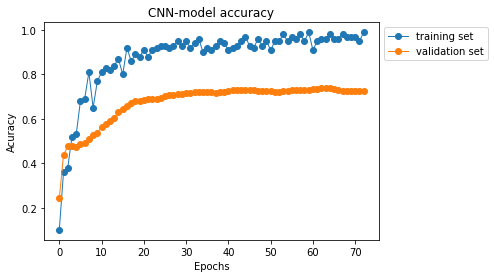

In [ ]:
plt.plot(hist_best_model_CNN.history['accuracy'], label='training set',marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.plot(hist_best_model_CNN.history['val_accuracy'], label='validation set',marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.title("CNN-model accuracy")
plt.xlabel('Epochs')
plt.ylabel('Acuracy')
plt.legend(bbox_to_anchor=( 1., 1.))

Ici, on affiche la loss du modèle en fonction du nombre d'epochs.

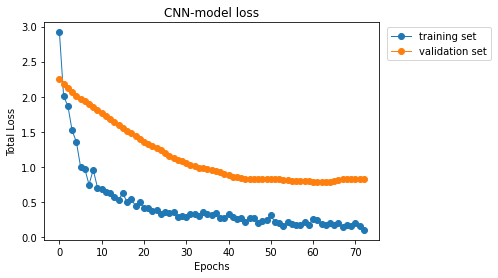

In [ ]:
plt.plot(hist_best_model_CNN.history['loss'], label='training set',marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.plot(hist_best_model_CNN.history['val_loss'], label='validation set',marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.title("CNN-model loss")
plt.xlabel('Epochs')
plt.ylabel('Total Loss')
plt.legend(bbox_to_anchor=( 1.35, 1.))

L'accuracy maximale obtenu sur les données de validation est : 0.7380 (epoch 64-65)

### Bilan

On constate que les modèles MLP et CNN n'ont que 1% d'écart concernant l'accuracy maximale.
On peut donc utiliser ces valeurs de référence pour savoir si notre méthode semi-supervisée est efficace.

# Réseaux de neurones semi-supervisés

## Paramètres des modèles

On choisit 50 epochs pour les modèles semi-supervisés. Le temps de calcul étant très long, il a fallu faire des compromis.
Concernant les variables `train_acc_history`, `val_acc_history`,`train_loss_history` et `val_loss_history`, ces dernières nous serviront pour tracer les courbes de la loss et de l'accuracy en fonction du nombre d'epochs.

In [ ]:
EPOCHS = 50
BATCH_SIZE_Sup = 16 # -> 7 batch pour 1 epoch
BATCH_SIZE_Unsup = 8192
#BUFFER_SIZE = 60000
#DISPLAY_STEP = 20
train_acc_history=np.zeros(EPOCHS)
val_acc_history=np.zeros(EPOCHS)
train_loss_history=np.zeros(EPOCHS)
val_loss_history=np.zeros(EPOCHS)

Définition de la fonction de perte du modèle.
<br>
Celle-ci prend en compte une perte sur la partie supervisée ainsi qu'une perte sur la partie non-supervisée comme décrit dans l'article Xie20.



In [ ]:
def model_loss(y_true_sup,y_pred_sup,y_pred_X,y_pred_X_chapeau,lamb=1):
  sup_loss=tf.keras.losses.categorical_crossentropy(y_true_sup, y_pred_sup, from_logits=False, label_smoothing=0)
  unsup_loss=tf.math.reduce_mean(tf.keras.losses.categorical_crossentropy(y_pred_X,y_pred_X_chapeau, from_logits=False, label_smoothing=0))
  total_loss = sup_loss + lamb * unsup_loss
  return total_loss

## Data Augmentation

Notre data augmentation se base sur l'objet `tf.keras.preprocessing.image.ImageDataGenerator`qui nous permet d'appliquer aléatoirement des transformations prédéfinies.
<br>
Ici, les transformations possibles sont: des zooms, des rotations, des élargissements et des perspectives. <br>
On n'applique pas d'inversions verticales ou horizontales car dans notre cas pour certains nombres on obtiendrait une représentation totalement faussée. Par exemple : Un 6 deviendrait un 9 après un vertical_flip.
<br>
De plus, on rajoute une fonction qui une fois sur deux applique un léger bruit gaussien sur les données.

In [ ]:
def add_noise(img):
    img2=np.copy(img)
    '''Add random noise to an image'''
    #VARIABILITY = 1./255
    #deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, (40/255)**2, img2.shape)
    img2 += noise
    np.clip(img2, 0., 255.)
    return img2

img_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,horizontal_flip=False,vertical_flip=False,rotation_range=30,zoom_range=0.1,width_shift_range=0.05,
        height_shift_range=0.05,shear_range=7
)

def DataAugmentation(img):
  img2=img_gen.apply_transform(np.reshape(img,[28,28,1]),img_gen.get_random_transform((28,28,1)))
  img2=np.reshape(img2,(28,28))
  if(np.random.uniform()>=0.5):
    img2=add_noise(img2)
  return(img2)

Exemple d'image avant Data Augmentation.

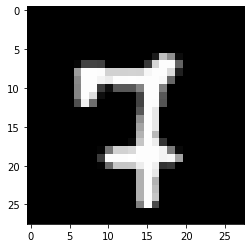

In [ ]:
plt.imshow((x_val[2]),cmap='gray')

Exemple d'image après Data Augmentation.

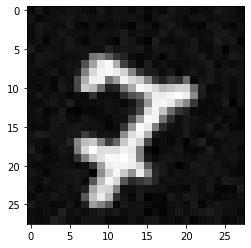

In [ ]:
plt.imshow(DataAugmentation(x_val[2]),cmap='gray')

## Perceptron multicouches (MLP)

In [ ]:
clear_session()

On utilisera le modèle optimal déterminé précédemment.

In [ ]:
best_model_MLP = tuner.hypermodel.build(best_hps_MLP)

On affiche un résumé de ce modèle.

In [ ]:
best_model_MLP.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
re_lu (ReLU)                 (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1

Choix de l'optimiseur.

In [ ]:
MLP_optimizer = tf.keras.optimizers.Adam(lr=0.8*1e-2)

Définition de la fonction permettant d'entrainer le modèle sur les données labélisées et non labélisées.

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step_MLP(x,y_true,x_chapeau,y_pred_x_unsup,lamb=1):
    #z = tf.random.normal([BATCH_SIZE, dim_z])

    with tf.GradientTape() as grad_tape:
      y_pred_sup = best_model_MLP(x, training=True)
      #fake_output = discriminator(generated_images, training=True)
      y_pred_x_chapeau = best_model_MLP(x_chapeau, training=False)

      MLP_loss = model_loss(y_true, y_pred_sup,y_pred_x_unsup,y_pred_x_chapeau,lamb)

      gradients_of_MLP = grad_tape.gradient(MLP_loss, best_model_MLP.trainable_variables)

      MLP_optimizer.apply_gradients(zip(gradients_of_MLP, best_model_MLP.trainable_variables))

#### Entrainement

In [ ]:

idx_history=0
for epoch in tqdm(np.arange(0,EPOCHS)):

  sup_batch_data=tf.data.Dataset.from_tensor_slices((x_labeled,y_labeled)).shuffle(x_labeled.shape[0]).batch(BATCH_SIZE_Sup)
  iterator_sup = sup_batch_data.__iter__() 

  y_pred_X_unsup=best_model_MLP(x_unlabeled,training=False)
  unsup_batch_data = tf.data.Dataset.from_tensor_slices((x_unlabeled,y_pred_X_unsup)).shuffle(x_unlabeled.shape[0]).batch(BATCH_SIZE_Unsup)
  iterator_unsup = unsup_batch_data.__iter__() 
  
  for batch in range(7):
      x_sup_batch,y_true_batch = iterator_sup.get_next()
      x_unsup_batch,y_pred_X_unsup_batch = iterator_unsup.get_next()
      
      x_chapeau=np.array(x_unsup_batch)
      for i in range(x_unsup_batch.shape[0]):
        x_chapeau[i]=DataAugmentation(x_chapeau[i])

      train_step_MLP(x_sup_batch,np.matrix(y_true_batch),x_chapeau,np.matrix(y_pred_X_unsup_batch),1)

  y_pred_labeled=best_model_MLP(x_labeled,training=False)
  y_pred_labeled_class=np.argmax(y_pred_labeled,axis=1)
  y_pred_val=best_model_MLP(x_val,training=False)
  y_pred_val_class=np.argmax(y_pred_val,axis=1)

  train_acc_history[idx_history]= np.mean(np.argmax(y_labeled,axis=1)==y_pred_labeled_class)
  val_acc_history[idx_history]= np.mean(np.argmax(y_val,axis=1)==y_pred_val_class)
  train_loss_history[idx_history]= np.mean(tf.keras.losses.categorical_crossentropy(y_labeled, y_pred_labeled,
                                                                          from_logits=False, label_smoothing=0))
  val_loss_history[idx_history]= np.mean(tf.keras.losses.categorical_crossentropy(y_val, y_pred_val,
                                                                        from_logits=False, label_smoothing=0))

  print("train loss : ", train_loss_history[idx_history] ,
        "train acc: ", train_acc_history[idx_history])
  
  print("val loss : ",val_loss_history[idx_history] ,
        "val acc: ",val_acc_history[idx_history])
  idx_history+=1;

  2%|▏         | 1/50 [00:19<15:38, 19.15s/it]

train loss :  1.4733514785766602 train acc:  0.66
val loss :  1.7785990238189697 val acc:  0.4729


  4%|▍         | 2/50 [00:36<14:58, 18.71s/it]

train loss :  0.9397721886634827 train acc:  0.84
val loss :  1.414174199104309 val acc:  0.5889


  6%|▌         | 3/50 [00:54<14:24, 18.39s/it]

train loss :  0.6653974056243896 train acc:  0.85
val loss :  1.239542007446289 val acc:  0.6174


  8%|▊         | 4/50 [01:12<13:56, 18.19s/it]

train loss :  0.4683857262134552 train acc:  0.92
val loss :  1.1074442863464355 val acc:  0.6499


 10%|█         | 5/50 [01:29<13:31, 18.03s/it]

train loss :  0.34012722969055176 train acc:  0.95
val loss :  0.9973939657211304 val acc:  0.6944


 12%|█▏        | 6/50 [01:47<13:06, 17.87s/it]

train loss :  0.2658334970474243 train acc:  0.94
val loss :  0.931689441204071 val acc:  0.7129


 14%|█▍        | 7/50 [02:04<12:43, 17.75s/it]

train loss :  0.22577506303787231 train acc:  0.97
val loss :  0.9182013869285583 val acc:  0.704


 16%|█▌        | 8/50 [02:22<12:23, 17.69s/it]

train loss :  0.1803203523159027 train acc:  0.96
val loss :  0.879204273223877 val acc:  0.7066


 18%|█▊        | 9/50 [02:39<12:03, 17.65s/it]

train loss :  0.15414877235889435 train acc:  0.98
val loss :  0.8847832083702087 val acc:  0.7068


 20%|██        | 10/50 [02:57<11:47, 17.69s/it]

train loss :  0.1274416148662567 train acc:  1.0
val loss :  0.8942939639091492 val acc:  0.7102


 22%|██▏       | 11/50 [03:15<11:28, 17.66s/it]

train loss :  0.11810291558504105 train acc:  0.98
val loss :  0.8679462671279907 val acc:  0.7197


 24%|██▍       | 12/50 [03:32<11:08, 17.60s/it]

train loss :  0.11456487327814102 train acc:  0.99
val loss :  0.8565897345542908 val acc:  0.7292


 26%|██▌       | 13/50 [03:50<10:49, 17.56s/it]

train loss :  0.10634942352771759 train acc:  0.98
val loss :  0.8450413942337036 val acc:  0.7381


 28%|██▊       | 14/50 [04:07<10:30, 17.52s/it]

train loss :  0.08190315216779709 train acc:  0.99
val loss :  0.8279873728752136 val acc:  0.7446


 30%|███       | 15/50 [04:25<10:12, 17.51s/it]

train loss :  0.09933825582265854 train acc:  0.98
val loss :  0.837378203868866 val acc:  0.7455


 32%|███▏      | 16/50 [04:42<09:55, 17.50s/it]

train loss :  0.13575802743434906 train acc:  0.95
val loss :  0.8540054559707642 val acc:  0.7565


 34%|███▍      | 17/50 [05:00<09:37, 17.51s/it]

train loss :  0.14417506754398346 train acc:  0.98
val loss :  0.8501114249229431 val acc:  0.7564


 36%|███▌      | 18/50 [05:17<09:21, 17.53s/it]

train loss :  0.1500430554151535 train acc:  0.97
val loss :  0.8420314192771912 val acc:  0.753


 38%|███▊      | 19/50 [05:35<09:02, 17.50s/it]

train loss :  0.14354544878005981 train acc:  0.97
val loss :  0.8451436758041382 val acc:  0.7512


 40%|████      | 20/50 [05:52<08:44, 17.48s/it]

train loss :  0.10308994352817535 train acc:  0.98
val loss :  0.8167775273323059 val acc:  0.7482


 42%|████▏     | 21/50 [06:10<08:26, 17.47s/it]

train loss :  0.08890751004219055 train acc:  0.98
val loss :  0.7762243747711182 val acc:  0.757


 44%|████▍     | 22/50 [06:27<08:09, 17.50s/it]

train loss :  0.07951147854328156 train acc:  0.98
val loss :  0.7610383629798889 val acc:  0.7648


 46%|████▌     | 23/50 [06:45<07:52, 17.51s/it]

train loss :  0.07109956443309784 train acc:  0.98
val loss :  0.727156937122345 val acc:  0.7682


 48%|████▊     | 24/50 [07:02<07:34, 17.49s/it]

train loss :  0.07199524343013763 train acc:  0.98
val loss :  0.727662205696106 val acc:  0.7684


 50%|█████     | 25/50 [07:20<07:16, 17.48s/it]

train loss :  0.07451101392507553 train acc:  0.99
val loss :  0.7307180166244507 val acc:  0.7686


 52%|█████▏    | 26/50 [07:37<06:59, 17.48s/it]

train loss :  0.05919317901134491 train acc:  0.99
val loss :  0.6758828163146973 val acc:  0.7794


 54%|█████▍    | 27/50 [07:55<06:42, 17.49s/it]

train loss :  0.06383706629276276 train acc:  0.99
val loss :  0.6565963625907898 val acc:  0.7841


 56%|█████▌    | 28/50 [08:12<06:26, 17.55s/it]

train loss :  0.07686182111501694 train acc:  0.99
val loss :  0.7001119256019592 val acc:  0.7651


 58%|█████▊    | 29/50 [08:30<06:08, 17.55s/it]

train loss :  0.09670224785804749 train acc:  0.96
val loss :  0.7341501712799072 val acc:  0.7582


 60%|██████    | 30/50 [08:47<05:50, 17.51s/it]

train loss :  0.0841996967792511 train acc:  0.98
val loss :  0.7395764589309692 val acc:  0.7546


 62%|██████▏   | 31/50 [09:05<05:31, 17.47s/it]

train loss :  0.06690800189971924 train acc:  1.0
val loss :  0.7133951187133789 val acc:  0.7742


 64%|██████▍   | 32/50 [09:22<05:15, 17.53s/it]

train loss :  0.054273560643196106 train acc:  1.0
val loss :  0.6889132857322693 val acc:  0.7863


 66%|██████▌   | 33/50 [09:40<04:58, 17.57s/it]

train loss :  0.04448161646723747 train acc:  1.0
val loss :  0.6695630550384521 val acc:  0.7887


 68%|██████▊   | 34/50 [09:58<04:41, 17.57s/it]

train loss :  0.05086261406540871 train acc:  1.0
val loss :  0.682593584060669 val acc:  0.7839


 70%|███████   | 35/50 [10:15<04:24, 17.61s/it]

train loss :  0.057064469903707504 train acc:  1.0
val loss :  0.6837013363838196 val acc:  0.7834


 72%|███████▏  | 36/50 [10:33<04:08, 17.72s/it]

train loss :  0.056743230670690536 train acc:  0.98
val loss :  0.68277907371521 val acc:  0.7894


 74%|███████▍  | 37/50 [10:51<03:49, 17.68s/it]

train loss :  0.06279748678207397 train acc:  0.98
val loss :  0.6981990337371826 val acc:  0.7877


 76%|███████▌  | 38/50 [11:08<03:31, 17.66s/it]

train loss :  0.07312654703855515 train acc:  0.98
val loss :  0.7138347625732422 val acc:  0.7806


 78%|███████▊  | 39/50 [11:26<03:13, 17.63s/it]

train loss :  0.06982499361038208 train acc:  0.99
val loss :  0.7176634669303894 val acc:  0.7751


 80%|████████  | 40/50 [11:43<02:56, 17.60s/it]

train loss :  0.057876814156770706 train acc:  0.99
val loss :  0.7085577845573425 val acc:  0.7776


 82%|████████▏ | 41/50 [12:01<02:38, 17.57s/it]

train loss :  0.055263813585042953 train acc:  0.99
val loss :  0.7132494449615479 val acc:  0.7806


 84%|████████▍ | 42/50 [12:18<02:20, 17.55s/it]

train loss :  0.05530370771884918 train acc:  0.99
val loss :  0.7054254412651062 val acc:  0.7824


 86%|████████▌ | 43/50 [12:36<02:02, 17.55s/it]

train loss :  0.041257426142692566 train acc:  1.0
val loss :  0.6674085855484009 val acc:  0.7928


 88%|████████▊ | 44/50 [12:54<01:45, 17.54s/it]

train loss :  0.034152451902627945 train acc:  1.0
val loss :  0.6509100794792175 val acc:  0.7982


 90%|█████████ | 45/50 [13:11<01:27, 17.58s/it]

train loss :  0.03627154976129532 train acc:  1.0
val loss :  0.6573553681373596 val acc:  0.793


 92%|█████████▏| 46/50 [13:29<01:10, 17.67s/it]

train loss :  0.03541475161910057 train acc:  1.0
val loss :  0.6790674924850464 val acc:  0.7855


 94%|█████████▍| 47/50 [13:47<00:52, 17.65s/it]

train loss :  0.03279735893011093 train acc:  1.0
val loss :  0.6512068510055542 val acc:  0.7867


 96%|█████████▌| 48/50 [14:04<00:35, 17.65s/it]

train loss :  0.029161987826228142 train acc:  1.0
val loss :  0.6203232407569885 val acc:  0.7935


 98%|█████████▊| 49/50 [14:22<00:17, 17.61s/it]

train loss :  0.03869617357850075 train acc:  0.99
val loss :  0.6299441456794739 val acc:  0.785


100%|██████████| 50/50 [14:40<00:00, 17.60s/it]

train loss :  0.05200381577014923 train acc:  0.99
val loss :  0.6803622841835022 val acc:  0.7737


#### Résultats

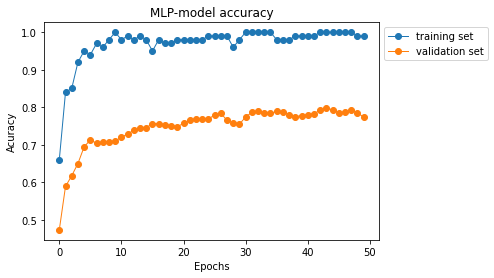

In [ ]:
plt.plot(train_acc_history, label='training set',marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.plot(val_acc_history, label='validation set',marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.title("MLP-model accuracy")
plt.xlabel('Epochs')
plt.ylabel('Acuracy')
plt.legend(bbox_to_anchor=( 1., 1.))

Ici, on affiche la loss du modèle en fonction du nombre d'epochs.

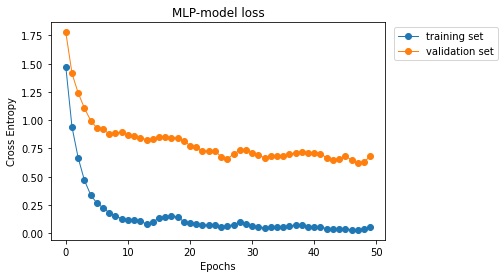

In [ ]:
plt.plot(train_loss_history, label='training set',marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.plot(val_loss_history, label='validation set',marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.title("MLP-model loss")
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.legend(bbox_to_anchor=( 1.35, 1.))

L'accuracy maximale sur les données de validation est de : 0.7982 (epoch 44)

## Réseau de convolution (CNN)

In [ ]:
clear_session()

On utilisera le modèle optimal déterminé précédemment.

In [ ]:
best_model_CNN = tuner.hypermodel.build(best_hps_CNN)

On affiche un résumé de ce modèle.

In [ ]:
best_model_CNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
re_lu (ReLU)                 (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                2

Choix de l'optimiseur.

In [ ]:
CNN_optimizer = tf.keras.optimizers.Adam(lr=0.8*1e-2)

Définition de la fonction permettant d'entrainer le modèle sur les données labélisées et non labélisées.

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step_CNN(x,y_true,x_chapeau,y_pred_x_unsup,lamb=1):
    #z = tf.random.normal([BATCH_SIZE, dim_z])

    with tf.GradientTape() as grad_tape:
      y_pred_sup = best_model_CNN(x, training=True)
      #fake_output = discriminator(generated_images, training=True)
      y_pred_x_chapeau = best_model_CNN(x_chapeau, training=False)

      CNN_loss = model_loss(y_true, y_pred_sup,y_pred_x_unsup,y_pred_x_chapeau,lamb)

      gradients_of_CNN = grad_tape.gradient(CNN_loss, best_model_CNN.trainable_variables)

      CNN_optimizer.apply_gradients(zip(gradients_of_CNN, best_model_CNN.trainable_variables))

#### Entrainement

In [ ]:
idx_history=0

for epoch in tqdm(np.arange(0,EPOCHS)):
  sup_batch_data=tf.data.Dataset.from_tensor_slices((x_labeled,y_labeled)).shuffle(x_labeled.shape[0]).batch(BATCH_SIZE_Sup)
  iterator_sup = sup_batch_data.__iter__() 

  y_pred_X_unsup=best_model_CNN(x_unlabeled,training=False)
  unsup_batch_data = tf.data.Dataset.from_tensor_slices((x_unlabeled,y_pred_X_unsup)).shuffle(x_unlabeled.shape[0]).batch(BATCH_SIZE_Unsup)
  iterator_unsup = unsup_batch_data.__iter__() 

  for batch in range(7):
      x_sup_batch,y_true_batch = iterator_sup.get_next()
      x_unsup_batch,y_pred_X_unsup_batch = iterator_unsup.get_next()
      
      x_chapeau=np.array(x_unsup_batch)
      for i in range(x_unsup_batch.shape[0]):
        x_chapeau[i]=DataAugmentation(x_chapeau[i])

      train_step_CNN(x_sup_batch,np.matrix(y_true_batch),x_chapeau,np.matrix(y_pred_X_unsup_batch),1)

  y_pred_labeled=best_model_CNN(x_labeled,training=False)
  y_pred_labeled_class=np.argmax(y_pred_labeled,axis=1)
  y_pred_val=best_model_CNN(x_val,training=False)
  y_pred_val_class=np.argmax(y_pred_val,axis=1)

  train_acc_history[idx_history]= np.mean(np.argmax(y_labeled,axis=1)==y_pred_labeled_class)
  val_acc_history[idx_history]= np.mean(np.argmax(y_val,axis=1)==y_pred_val_class)
  train_loss_history[idx_history]= np.mean(tf.keras.losses.categorical_crossentropy(y_labeled, y_pred_labeled,
                                                                          from_logits=False, label_smoothing=0))
  val_loss_history[idx_history]= np.mean(tf.keras.losses.categorical_crossentropy(y_val, y_pred_val,
                                                                        from_logits=False, label_smoothing=0))

  print("train loss : ", train_loss_history[idx_history] ,
        "train acc: ", train_acc_history[idx_history])
  
  print("val loss : ",val_loss_history[idx_history] ,
        "val acc: ",val_acc_history[idx_history])
  idx_history+=1;

  2%|▏         | 1/50 [00:18<15:07, 18.51s/it]

train loss :  1.716706395149231 train acc:  0.46
val loss :  1.9568296670913696 val acc:  0.336


  4%|▍         | 2/50 [00:35<14:28, 18.09s/it]

train loss :  1.3353146314620972 train acc:  0.58
val loss :  1.7153631448745728 val acc:  0.4079


  6%|▌         | 3/50 [00:52<13:57, 17.82s/it]

train loss :  1.129077434539795 train acc:  0.63
val loss :  1.553699254989624 val acc:  0.4604


  8%|▊         | 4/50 [01:10<13:32, 17.67s/it]

train loss :  0.9954313635826111 train acc:  0.7
val loss :  1.4506545066833496 val acc:  0.5017


 10%|█         | 5/50 [01:27<13:09, 17.54s/it]

train loss :  0.8968708515167236 train acc:  0.71
val loss :  1.3970164060592651 val acc:  0.5289


 12%|█▏        | 6/50 [01:44<12:44, 17.37s/it]

train loss :  0.8169426918029785 train acc:  0.74
val loss :  1.3763540983200073 val acc:  0.537


 14%|█▍        | 7/50 [02:01<12:22, 17.28s/it]

train loss :  0.7042019367218018 train acc:  0.8
val loss :  1.3229570388793945 val acc:  0.5673


 16%|█▌        | 8/50 [02:18<12:03, 17.23s/it]

train loss :  0.6215086579322815 train acc:  0.8
val loss :  1.2774853706359863 val acc:  0.5802


 18%|█▊        | 9/50 [02:35<11:43, 17.17s/it]

train loss :  0.5563440918922424 train acc:  0.82
val loss :  1.2098045349121094 val acc:  0.6032


 20%|██        | 10/50 [02:52<11:25, 17.15s/it]

train loss :  0.48606327176094055 train acc:  0.87
val loss :  1.1553009748458862 val acc:  0.6301


 22%|██▏       | 11/50 [03:09<11:07, 17.12s/it]

train loss :  0.43432748317718506 train acc:  0.89
val loss :  1.1259074211120605 val acc:  0.6444


 24%|██▍       | 12/50 [03:26<10:48, 17.07s/it]

train loss :  0.382856547832489 train acc:  0.94
val loss :  1.0983091592788696 val acc:  0.6548


 26%|██▌       | 13/50 [03:43<10:32, 17.10s/it]

train loss :  0.3330869972705841 train acc:  0.95
val loss :  1.0562012195587158 val acc:  0.6666


 28%|██▊       | 14/50 [04:01<10:17, 17.14s/it]

train loss :  0.2710699737071991 train acc:  0.98
val loss :  0.9920439720153809 val acc:  0.6879


 30%|███       | 15/50 [04:18<09:59, 17.13s/it]

train loss :  0.24338935315608978 train acc:  0.97
val loss :  0.9711636900901794 val acc:  0.6935


 32%|███▏      | 16/50 [04:35<09:40, 17.09s/it]

train loss :  0.2500797510147095 train acc:  0.96
val loss :  0.9722961783409119 val acc:  0.6902


 34%|███▍      | 17/50 [04:52<09:23, 17.06s/it]

train loss :  0.21816925704479218 train acc:  0.97
val loss :  0.9725542068481445 val acc:  0.691


 36%|███▌      | 18/50 [05:09<09:04, 17.01s/it]

train loss :  0.19732999801635742 train acc:  0.97
val loss :  0.9689356684684753 val acc:  0.6901


 38%|███▊      | 19/50 [05:25<08:46, 16.97s/it]

train loss :  0.17705154418945312 train acc:  0.98
val loss :  0.951792299747467 val acc:  0.703


 40%|████      | 20/50 [05:42<08:29, 16.98s/it]

train loss :  0.17501311004161835 train acc:  0.97
val loss :  0.9446954131126404 val acc:  0.7138


 42%|████▏     | 21/50 [06:00<08:13, 17.02s/it]

train loss :  0.17093271017074585 train acc:  0.98
val loss :  0.9511665105819702 val acc:  0.7109


 44%|████▍     | 22/50 [06:17<07:56, 17.01s/it]

train loss :  0.16950348019599915 train acc:  0.98
val loss :  0.9692639708518982 val acc:  0.7078


 46%|████▌     | 23/50 [06:34<07:42, 17.15s/it]

train loss :  0.1609014868736267 train acc:  0.98
val loss :  0.9832838177680969 val acc:  0.6986


 48%|████▊     | 24/50 [06:51<07:27, 17.20s/it]

train loss :  0.155581995844841 train acc:  0.98
val loss :  0.9823594689369202 val acc:  0.6991


 50%|█████     | 25/50 [07:08<07:08, 17.16s/it]

train loss :  0.15470124781131744 train acc:  0.97
val loss :  0.9673163890838623 val acc:  0.7084


 52%|█████▏    | 26/50 [07:25<06:50, 17.12s/it]

train loss :  0.16051821410655975 train acc:  0.98
val loss :  0.9600908160209656 val acc:  0.7123


 54%|█████▍    | 27/50 [07:42<06:33, 17.09s/it]

train loss :  0.15247617661952972 train acc:  0.98
val loss :  0.9521833062171936 val acc:  0.7116


 56%|█████▌    | 28/50 [07:59<06:14, 17.04s/it]

train loss :  0.13859869539737701 train acc:  0.98
val loss :  0.9310662150382996 val acc:  0.7211


 58%|█████▊    | 29/50 [08:16<05:57, 17.00s/it]

train loss :  0.12874174118041992 train acc:  0.98
val loss :  0.9066336154937744 val acc:  0.7314


 60%|██████    | 30/50 [08:33<05:40, 17.01s/it]

train loss :  0.1199672669172287 train acc:  0.98
val loss :  0.8955521583557129 val acc:  0.7288


 62%|██████▏   | 31/50 [08:50<05:23, 17.00s/it]

train loss :  0.12763597071170807 train acc:  0.97
val loss :  0.8959003686904907 val acc:  0.7219


 64%|██████▍   | 32/50 [09:08<05:08, 17.12s/it]

train loss :  0.13646571338176727 train acc:  0.97
val loss :  0.8972106575965881 val acc:  0.7158


 66%|██████▌   | 33/50 [09:25<04:50, 17.10s/it]

train loss :  0.13268466293811798 train acc:  0.98
val loss :  0.8922590017318726 val acc:  0.713


 68%|██████▊   | 34/50 [09:42<04:33, 17.08s/it]

train loss :  0.14183896780014038 train acc:  0.97
val loss :  0.8962720632553101 val acc:  0.7112


 70%|███████   | 35/50 [09:59<04:15, 17.01s/it]

train loss :  0.1537615805864334 train acc:  0.96
val loss :  0.9085497856140137 val acc:  0.7047


 72%|███████▏  | 36/50 [10:16<03:57, 16.99s/it]

train loss :  0.18534894287586212 train acc:  0.94
val loss :  0.9406066536903381 val acc:  0.6873


 74%|███████▍  | 37/50 [10:33<03:41, 17.01s/it]

train loss :  0.17088699340820312 train acc:  0.95
val loss :  0.925900399684906 val acc:  0.6887


 76%|███████▌  | 38/50 [10:49<03:23, 16.97s/it]

train loss :  0.15815891325473785 train acc:  0.96
val loss :  0.941824197769165 val acc:  0.6867


 78%|███████▊  | 39/50 [11:07<03:06, 16.99s/it]

train loss :  0.17422956228256226 train acc:  0.98
val loss :  0.9583114981651306 val acc:  0.6902


 80%|████████  | 40/50 [11:23<02:49, 16.97s/it]

train loss :  0.1346869170665741 train acc:  0.99
val loss :  0.8800649642944336 val acc:  0.724


 82%|████████▏ | 41/50 [11:40<02:32, 16.98s/it]

train loss :  0.11317454278469086 train acc:  1.0
val loss :  0.8318871855735779 val acc:  0.7443


 84%|████████▍ | 42/50 [11:58<02:16, 17.03s/it]

train loss :  0.10534896701574326 train acc:  0.99
val loss :  0.8069719672203064 val acc:  0.7524


 86%|████████▌ | 43/50 [12:15<01:59, 17.07s/it]

train loss :  0.09802528470754623 train acc:  0.99
val loss :  0.7784925103187561 val acc:  0.7606


 88%|████████▊ | 44/50 [12:32<01:42, 17.07s/it]

train loss :  0.09791146963834763 train acc:  0.99
val loss :  0.7698832154273987 val acc:  0.7623


 90%|█████████ | 45/50 [12:49<01:25, 17.01s/it]

train loss :  0.09856734424829483 train acc:  0.99
val loss :  0.7742301821708679 val acc:  0.7599


 92%|█████████▏| 46/50 [13:06<01:07, 16.99s/it]

train loss :  0.09559573978185654 train acc:  0.99
val loss :  0.7687009572982788 val acc:  0.7583


 94%|█████████▍| 47/50 [13:23<00:51, 17.00s/it]

train loss :  0.08843925595283508 train acc:  1.0
val loss :  0.7634419798851013 val acc:  0.7591


 96%|█████████▌| 48/50 [13:40<00:34, 17.01s/it]

train loss :  0.07656219601631165 train acc:  1.0
val loss :  0.7541550397872925 val acc:  0.7626


 98%|█████████▊| 49/50 [13:57<00:17, 17.02s/it]

train loss :  0.06391929090023041 train acc:  1.0
val loss :  0.7573872804641724 val acc:  0.7652


100%|██████████| 50/50 [14:14<00:00, 17.10s/it]

train loss :  0.07328065484762192 train acc:  1.0
val loss :  0.7817725539207458 val acc:  0.7551


#### Résultats

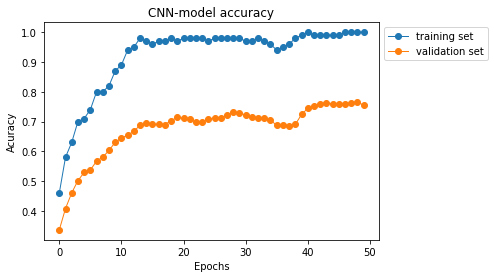

In [ ]:
plt.plot(train_acc_history, label='training set',marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.plot(val_acc_history, label='validation set',marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.title("CNN-model accuracy")
plt.xlabel('Epochs')
plt.ylabel('Acuracy')
plt.legend(bbox_to_anchor=( 1., 1.))

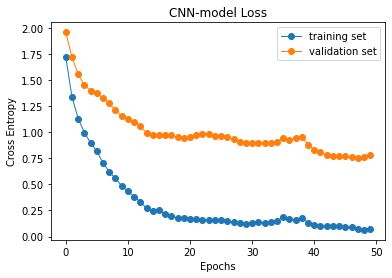

In [ ]:
plt.plot(train_loss_history, label='training set',marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.plot(val_loss_history, label='validation set',marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.title("CNN-model Loss")
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.legend(bbox_to_anchor=( 1., 1.))

L'accuracy maximale sur les données de validation est de : 0.7652 (epoch 49)

# Conclusion

Pour la partie non-supervisé on constate qu'on a une plus grande amélioration, et une plus grande accuracy, avec le modèle MLP.

Par contre, on peut constater que pour les deux modèles, l'amélioration est présente.

Pour le MLP, on passe de 72.8% à 79.82% soit un gain de 7.02%.

Pour le CNN, on passe de 73.8% à 76.52%, soit un gain de 2.72%.

Par ailleurs l'amélioration dépend fortement de la DataAugmentation, on peut donc supposer qu'un meilleur choix de paramètres, plus adapté au modèle CNN, pourrait grandement améliorer ses performances.

De plus, ici on n'est que sur une base d'une cinquantaine d'epochs car nous sommes limités en puissance de calcul. Avec plus de puissance, nous aurions pu mieux peaufiner le choix des paramètres concernant la DataAugmentation ainsi que le paramètre de régularisation $\lambda$ (ici $\lambda = 1$).